# Chapter 4: Multilayer Perceptrons
#### Setion 4.5: Weight Decay

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

#### Generating the Dataset

In [5]:
# num_inputs polinomial degree 200
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

#### Initialize model params

In [6]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### Defining L2 Norm Penalty

In [7]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### Training Loop

In [9]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

#### Training without Regularization

L2 norm of w: 13.962212562561035


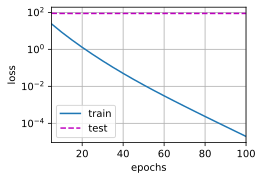

In [10]:
train(lambd=0)

#### Using Weight Decay

L2 norm of w: 0.3591443598270416


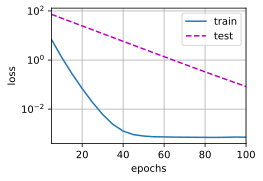

In [11]:
train(lambd=3)

#### Concise Implementation

In [12]:
# By default, PyTorch decays both weights and biases simultaneously.
# Here we only set weight_decay for the weight, so the bias parameter b will not decay.

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 12.265167236328125


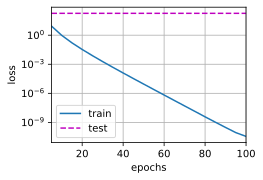

In [13]:
# lambda = 0
train_concise(0)

L2 norm of w: 0.519712507724762


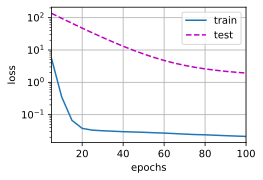

In [14]:
# We add some regularization lambda = 3
train_concise(3)

***Notes:***

* L1-regularized linear regression is a similarly fundamental model in statistics, which is popularly known as ***lasso regression***.

* L2 norm is that it places an outsize penalty on large components of the weight vector. This biases our learning algorithm towards models that distribute weight evenly across a larger number of features. In practice, this might make them more robust to measurement error in a single variable. By contrast, ***L1*** penalties lead to models that concentrate weights on a small set of features by clearing the other weights to zero. This is called feature selection, which may be desirable for other reasons.

* As before, we update w based on the amount by which our estimate differs from the observation. However, we also shrink the size of w towards zero. That is why the method is sometimes called “weight decay”: given the penalty term alone, our optimization algorithm decays the weight at each step of training. In contrast to feature selection, weight decay offers us a continuous mechanism for adjusting the complexity of a function. Smaller values of λ correspond to less constrained w, whereas larger values of λ constrain w more considerably.

* Whether we include a corresponding bias penalty b^22 (instead of w^2) can vary across implementations, and may vary across layers of a neural network. Often, we do not regularize the bias term of a network’s output layer

* Extension for simple nonlinear function can be a complex question. For instance, reproducing kernel Hilbert space (RKHS) allows one to apply tools introduced for linear functions in a nonlinear context. Unfortunately, RKHS-based algorithms tend to scale poorly to large, high-dimensional data. 